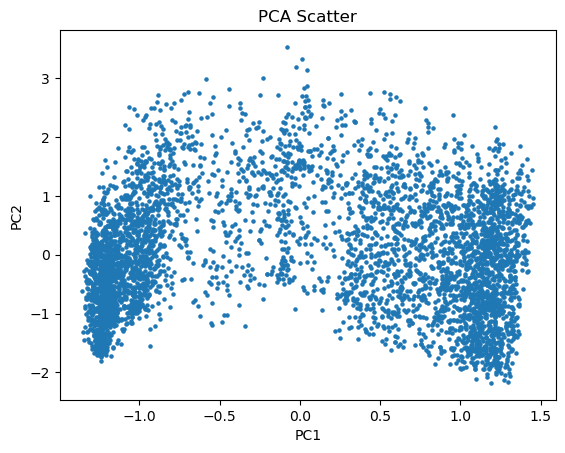

In [1]:
import csv
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

in_path = "../example/data.csv"

pc1_vals = []
pc2_vals = []
indices = []

# Load using csv module
with open(in_path, "r", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        indices.append(row["index"])
        pc1_vals.append(float(row["pc1"]))
        pc2_vals.append(float(row["pc2"]))

# Make a scatter plot (no styles/colors specified)
plt.figure();
plt.scatter(pc1_vals, pc2_vals, s=5);
plt.xlabel("PC1");
plt.ylabel("PC2");
plt.title("PCA Scatter");
plt.show();
plt.close();

In [2]:
class PCADataset:
    def __init__(self, csv_path):
        self.csv_path = Path(csv_path)
        self.data = []
        self._load()

    def _load(self):
        with self.csv_path.open("r", newline="") as f:
            reader = csv.DictReader(f)
            for row in reader:
                index = row["index"]
                pc1 = float(row["pc1"])
                pc2 = float(row["pc2"])
                T   = float(row.get("T", 1.0))
                T += np.random.random()*1e-1                
                self.data.append((index, pc1, pc2, T))

    def __len__(self):
        return len(self.data)

    def _perturb(self, val, scale=1e-1):
        noise = scale*(2*np.random.uniform() - 1)
        return val + noise
        
        

    def __getitem__(self, i):
        index, pc1, pc2, T = self.data[i]
        temps = np.array([[T]], dtype=float)        # (1, 1)
        coords = np.zeros((2, 2), dtype=float)      # (2, 2)
        coords[0, :] = [pc1, pc2]                   # PCA row
        coords[1, :] = [self._perturb(T) for _ in range(2)]       
        return index, torch.Tensor(temps), torch.Tensor(coords)


In [3]:
# from tm.architectures.unet_1d import Unet1D
from tm.architectures.mlp import MLP

from tm.core.backbone import MLPBackbone
from tm.core.diffusion_process import VPDiffusion
from tm.core.prior import GlobalEquilibriumHarmonicPrior as Prior
from tm.core.diffusion_model import DiffusionTrainer, DiffusionSampler
from torch.utils.data import RandomSampler

In [4]:
train_loader = PCADataset(in_path)

In [5]:
full_shape = [1] + list(train_loader.__getitem__(0)[-1].shape)
full_shape

[1, 2, 2]

In [6]:
def next_divisible_by_groups(n, groups):
    remainder = n % groups
    if remainder == 0:
        return n  # The number is already divisible by 'groups'
    else:
        return n + (groups - remainder)

In [42]:
train_loader = PCADataset(in_path)

train_sampler = RandomSampler(train_loader)

model =MLP(dim=64, #recommend dim=128 if enough memory
           num_resolutions=16,
           mlp_hidden_mult=16,
           dropout=0.05,
           learned_variance=False,
           self_condition=True,
           resnet_block_groups=8,
           learned_sinusoidal_cond=True,
           channels=2
)

backbone = MLPBackbone(model=model,
                        # data_shape=full_shape[-1],
                        # target_shape=next_divisible_by_groups(full_shape[-1], 8),
                        # num_dims=3,
                        lr=1e-4,
                        eval_mode="train",
                        self_condition=True,
                        # interpolate=True
                      )

diffusion = VPDiffusion(num_diffusion_timesteps=10)

prior = Prior(shape=full_shape, channels_info={"coordinate": [0], "fluctuation": [1]})

ERROR! Session/line number was not unique in database. History logging moved to new session 89
Using device  cpu for TM


In [43]:
trainer = DiffusionTrainer(diffusion,
                           backbone,
                           train_loader,
                           prior,
                           model_dir='../example/models',
                           network_pred_type='noise',
                           train_sampler=train_sampler,
                           )

In [44]:
trainer.train(80, loss_type="l2", batch_size=32)

epoch: 0 | train loss: 2.235
epoch: 1 | train loss: 1.320
epoch: 2 | train loss: 1.210
epoch: 3 | train loss: 1.194
epoch: 4 | train loss: 1.137
epoch: 5 | train loss: 1.127
epoch: 6 | train loss: 1.126


KeyboardInterrupt: 

In [45]:
model_dir = '../example/models'
backbone.load_model(model_dir, epoch='latest')

load_state using device choice: cpu


In [46]:
diffusion = VPDiffusion(num_diffusion_timesteps=5)
sampler = DiffusionSampler(diffusion, backbone, train_loader, prior, network_pred_type='noise')

In [ ]:
output_dict = {}
direction = 'forward'
T = 1

# If OOM error reduce batch size
data_loader = torch.utils.data.DataLoader(train_loader, batch_size=64, shuffle=False, pin_memory=True)

for batch_index, (index, temperatures, b) in enumerate(tqdm(data_loader, desc="Processing batches")):
    batch_size = b.size(0)
    if index not in output_dict.keys():
        for index_ in index:
            output_dict[index_] = {'target': [], 'prior': [], 'delta_log_pq': [], 'log_p': [], 'log_q': []}

    output_dict_ = sampler.sample_batch(x0=b, 
                                        mode=direction, 
                                        eta=0, # 0 is ODE, 1 is SDE
                                        gamma=0, # control some of the channels (0 is no control)
                                        batch_size=batch_size,
                                        temperatures=T, # can be scalar of vector (len is num samples)
                                        likelihood=True,
                                        control_dict={}, 
                                        pred_type='noise')

    for i_, index_ in enumerate(index):
        for k,v in output_dict_.items():
            output_dict[index_][k] = output_dict_[k][i_]

Processing batches:   6%|██▉                                          | 5/78 [00:07<01:48,  1.48s/it]

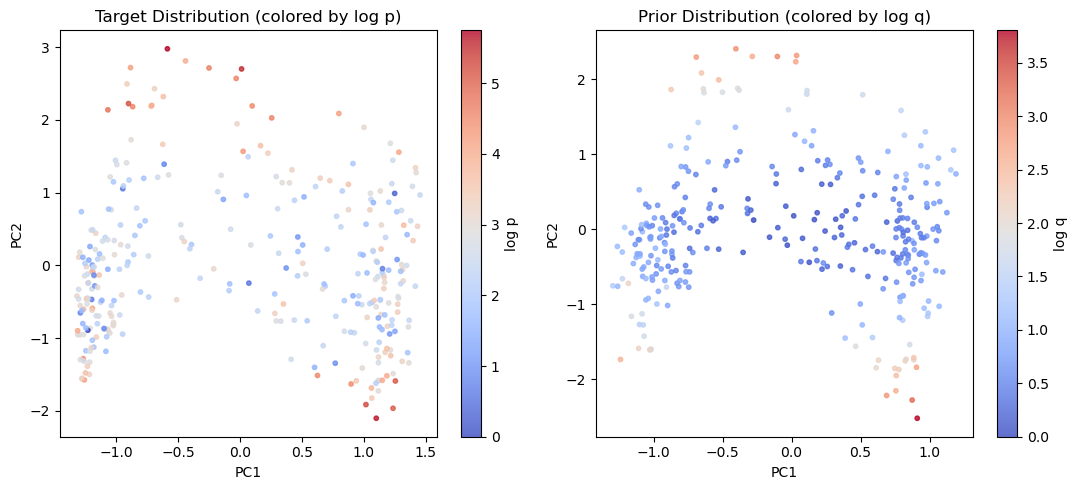

In [39]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    if entry:
        try:
            targets.append(entry["target"][0])  # 0 - coordinates, 1 - temperatures
            priors.append(entry["prior"][0])
            logp.append(float(entry["log_p"]))
            logq.append(float(entry["log_q"]))
        except:
            None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sc1 = axes[0].scatter(targets[:, 0], targets[:, 1], c=logp, cmap='coolwarm', s=10, alpha=0.8)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

sc2 = axes[1].scatter(priors[:, 0], priors[:, 1], c=logq, cmap='coolwarm', s=10, alpha=0.8)
axes[1].set_title("Prior Distribution (colored by log q)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label='log q')

plt.tight_layout()
plt.show()


In [27]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    # if len(entry) == 2:
        try:
            # print(entry['target'].shape)
            targets.append(entry["target"][None,:,:])  # 0 - coordinates, 1 - temperatures
            priors.append(entry["prior"][None,:,:])
            logp.append(float(entry["log_p"]))
            logq.append(float(entry["log_q"]))
        except:
            None
targets_ = np.array(targets).squeeze()
priors_ = np.array(priors).squeeze()


In [28]:
np.save('prior_endpoints.npy', priors_)

In [29]:
priors_ = np.load('prior_endpoints.npy')

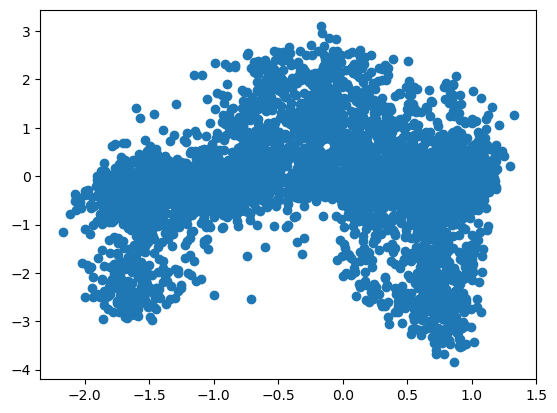

In [11]:
plt.scatter(priors_[:,0,0], priors_[:,0,1])

In [30]:
# Parameters
batch_size = 256
N = 256*19

T = 1
direction = "reverse"

output_dict = {}  # will hold N unique indices: 0..N-1

# How many batches we need
import math
num_batches = math.ceil(N / batch_size)

lb = 0
ub = batch_size

# Main loop
global_idx = 0
for b_ix in tqdm(range(num_batches)):
    # Adjust batch size for the final (possibly smaller) batch
    bs = min(batch_size, N - global_idx)
    if bs <= 0:
        break

    # Prior for this batch
    b = prior.sample(batch_size=bs, temperatures=T)
    b = priors_
    # np.random.shuffle(b)
    b = b[lb:ub]
    b = np.array([b_ for b_ in b])
    b = torch.Tensor(b)
    lb += batch_size
    ub += batch_size

    # Run sampler on this batch
    output_dict_batch = sampler.sample_batch(
        x0=b,
        mode=direction,
        eta=0,              # 0 is ODE, 1 is SDE
        gamma=0,            # 0 = no control
        batch_size=bs,
        temperatures=T,     # scalar or vector (len = num samples)
        likelihood=True,
        control_dict={},
        pred_type="noise",
    )

    # Store results with unique global indices
    # Assumes output_dict_batch is a dict of arrays/tensors with first dim = bs
    for i in range(bs):
        idx = global_idx + i
        output_dict[idx] = {
            "target":        output_dict_batch["target"][i],
            "prior":         output_dict_batch["prior"][i],
            "delta_log_pq":  output_dict_batch["delta_log_pq"][i],
            "log_p":         output_dict_batch["log_p"][i],
            "log_q":         output_dict_batch["log_q"][i],
        }

    global_idx += bs

  5%|███▍                                                             | 1/19 [01:10<21:11, 70.67s/it]


KeyboardInterrupt: 

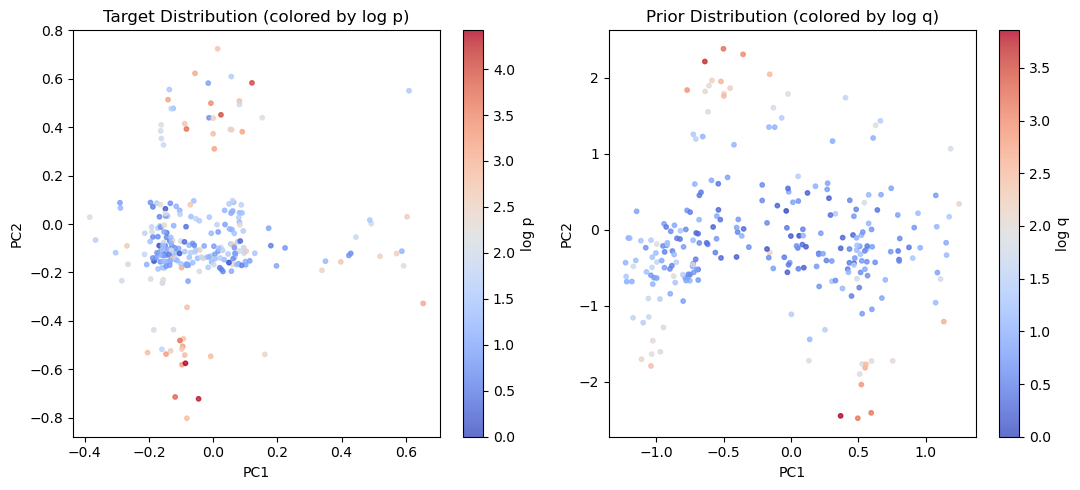

In [31]:
# Reveres diffusion dynamics are blowing up ... probably a sign wrong somewhere.

targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    try:
        targets.append(entry["target"][0])  # coordinate row
        priors.append(entry["prior"][0])
        logp.append(float(entry["log_p"]))
        logq.append(float(entry["log_q"]))
    except:
        None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sc1 = axes[0].scatter(targets[:, 0], targets[:, 1], c=logp, cmap='coolwarm', s=10, alpha=0.8)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

sc2 = axes[1].scatter(priors[:, 0], priors[:, 1], c=logq, cmap='coolwarm', s=10, alpha=0.8)
axes[1].set_title("Prior Distribution (colored by log q)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label='log q')

plt.tight_layout()
plt.show()


In [227]:
from tm.core.diffusion_process import cosine_noise_schedule

In [237]:
t = torch.arange(100)
alphas, betas = cosine_noise_schedule(t)

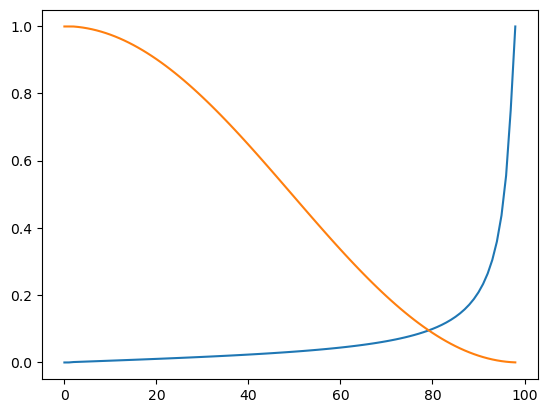

In [238]:
plt.plot(alphas)
plt.plot(betas)

In [239]:
sampler.get_adjacent_times(t)

[(tensor(0), tensor(1)),
 (tensor(1), tensor(2)),
 (tensor(2), tensor(3)),
 (tensor(3), tensor(4)),
 (tensor(4), tensor(5)),
 (tensor(5), tensor(6)),
 (tensor(6), tensor(7)),
 (tensor(7), tensor(8)),
 (tensor(8), tensor(9)),
 (tensor(9), tensor(10)),
 (tensor(10), tensor(11)),
 (tensor(11), tensor(12)),
 (tensor(12), tensor(13)),
 (tensor(13), tensor(14)),
 (tensor(14), tensor(15)),
 (tensor(15), tensor(16)),
 (tensor(16), tensor(17)),
 (tensor(17), tensor(18)),
 (tensor(18), tensor(19)),
 (tensor(19), tensor(20)),
 (tensor(20), tensor(21)),
 (tensor(21), tensor(22)),
 (tensor(22), tensor(23)),
 (tensor(23), tensor(24)),
 (tensor(24), tensor(25)),
 (tensor(25), tensor(26)),
 (tensor(26), tensor(27)),
 (tensor(27), tensor(28)),
 (tensor(28), tensor(29)),
 (tensor(29), tensor(30)),
 (tensor(30), tensor(31)),
 (tensor(31), tensor(32)),
 (tensor(32), tensor(33)),
 (tensor(33), tensor(34)),
 (tensor(34), tensor(35)),
 (tensor(35), tensor(36)),
 (tensor(36), tensor(37)),
 (tensor(37), tensor

In [240]:
sampler.get_adjacent_times(t, reverse=True)

[(tensor(99), tensor(98)),
 (tensor(98), tensor(97)),
 (tensor(97), tensor(96)),
 (tensor(96), tensor(95)),
 (tensor(95), tensor(94)),
 (tensor(94), tensor(93)),
 (tensor(93), tensor(92)),
 (tensor(92), tensor(91)),
 (tensor(91), tensor(90)),
 (tensor(90), tensor(89)),
 (tensor(89), tensor(88)),
 (tensor(88), tensor(87)),
 (tensor(87), tensor(86)),
 (tensor(86), tensor(85)),
 (tensor(85), tensor(84)),
 (tensor(84), tensor(83)),
 (tensor(83), tensor(82)),
 (tensor(82), tensor(81)),
 (tensor(81), tensor(80)),
 (tensor(80), tensor(79)),
 (tensor(79), tensor(78)),
 (tensor(78), tensor(77)),
 (tensor(77), tensor(76)),
 (tensor(76), tensor(75)),
 (tensor(75), tensor(74)),
 (tensor(74), tensor(73)),
 (tensor(73), tensor(72)),
 (tensor(72), tensor(71)),
 (tensor(71), tensor(70)),
 (tensor(70), tensor(69)),
 (tensor(69), tensor(68)),
 (tensor(68), tensor(67)),
 (tensor(67), tensor(66)),
 (tensor(66), tensor(65)),
 (tensor(65), tensor(64)),
 (tensor(64), tensor(63)),
 (tensor(63), tensor(62)),
 